In [54]:
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_yaml,model_from_json
import pyBigWig
import tensorflow as tf
import keras.backend as K
from pybedtools import BedTool
from genomelake.extractors import ArrayExtractor 
import pandas as pd
from copy import deepcopy 
sys.path.insert(0,'/srv/scratch/manyu/NIPS_workshop_tests/motif_analysis/')
from plot import seqlogo_fig




In [2]:
# %load_ext autoreload
# %autoreload 2

# import pwm_utils
# from pwm_utils import run_pipeline_with_all_pos_intervals
# from pwm_utils import plot_and_save_information_content_pwms

In [3]:
DEFER_DELETE_SIZE=int(250 * 1e6)
def create_tensorflow_session(visiblegpus):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(visiblegpus)
    session_config = tf.ConfigProto()
    session_config.gpu_options.deferred_deletion_bytes = DEFER_DELETE_SIZE
    session_config.gpu_options.per_process_gpu_memory_fraction = .95
    session = tf.Session(config=session_config)
    K.set_session(session)
    return session

sess = create_tensorflow_session(1)

In [4]:
def load_model(model_arch_path,model_weights_path):
    if 'json' in model_arch_path:
        with open(model_arch_path,'r') as f:
            model = model_from_json(f.read())
            model.load_weights(model_weights_path)
    if 'yaml' in model_arch_path:
        with open(model_arch_path,'r') as f:
            model = model_from_yaml(f.read())
            model.load_weights(model_weights_path)
    return model    
        
        


In [5]:
# path_to_model_arch = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/ZBTB33/train/logdir_seq_meth/model.arch.json'
# path_to_model_weights = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/ZBTB33/train/logdir_seq_meth/model.weights.h5'
# model = load_model(path_to_model_arch,path_to_model_weights)

In [6]:
def create_pos_intervals_bed(path_to_intervals,path_to_labels,test_chroms,path_to_pos_intervals_file=None):
    assert(os.path.exists(path_to_intervals))
    assert(os.path.exists(path_to_labels))
    labels = np.load(path_to_labels)
    labels = np.squeeze(labels)
    intervals_dataframe = BedTool(path_to_intervals).to_dataframe()
    intervals_dataframe['labels'] = pd.Series(labels,index = intervals_dataframe.index)
    pos_intervals = intervals_dataframe.loc[intervals_dataframe['labels']==1]
    pos_intervals_test = pos_intervals.loc[pos_intervals['chrom'].isin(test_chroms)]
    if not os.path.exists('./tmp'):
        os.makedirs('./tmp/')
    if not path_to_pos_intervals_file:
        path_to_pos_intervals_file = './tmp/pos_intervals.bed'
    pos_intervals_test_vals = pos_intervals_test.values
    with open(path_to_pos_intervals_file,'w') as f:
        for line in pos_intervals_test_vals:
            f.write(line[0]+'\t'+str(line[1])+'\t'+str(line[2])+'\n')
        f.close()    
    print("Created positive intervals file for the test chroms")
    return path_to_pos_intervals_file

In [7]:
# path_to_intervals = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/label_regions/\
# zbtb33/ZBTB33_bin200_flank400_stride200.K562.intervals.bed'
# path_to_labels = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/label_regions/\
# zbtb33/ZBTB33_bin200_flank400_stride200.K562.labels.npy'
# pos_file = create_pos_intervals_bed(path_to_intervals,path_to_labels,test_chroms=['chr9'])

In [8]:
def get_importance_scores(path_to_genome,path_to_methylation,path_to_pos_intervals_file,model):
    assert(os.path.exists(path_to_genome))
    assert(os.path.exists(path_to_methylation))
    assert(os.path.exists(path_to_pos_intervals_file))
    genome_extractor = ArrayExtractor(path_to_genome)
    meth_extractor = ArrayExtractor(path_to_methylation)
    pos_intervals_extracted_arr = genome_extractor(BedTool(path_to_pos_intervals_file))
    methylation = meth_extractor(BedTool(path_to_pos_intervals_file))
    pos_intervals_extracted_arr = np.transpose(pos_intervals_extracted_arr,[0,2,1])
    
    ##Compute gradients with respect to input layers
    seq_input = model.get_layer('data/genome_data_dir').input
    meth_input = model.get_layer('data/methylation_data_dir').input
    logit = K.sum(model.layers[-2].output,axis = 0)
    logit_grad = K.gradients(logit,[seq_input,meth_input])
    logit_gradients_func = K.function([seq_input, meth_input,K.learning_phase()], logit_grad)
    grad_seq,grad_meth = logit_gradients_func([pos_intervals_extracted_arr,methylation,False])
    
    ##input*grad importance scores
    input_grad_seq = grad_seq*pos_intervals_extracted_arr
    input_grad_meth  = grad_meth*methylation
    
    ##scores_dict
    raw = {'seq':pos_intervals_extracted_arr,'meth':methylation}
    grad = {'seq': grad_seq, 'meth':grad_meth}
    input_grad = {'seq':input_grad_seq,'meth':input_grad_meth}
    scores_dict = {'raw':raw,'grad':grad,'input_grad':input_grad}
    
    return scores_dict


    
    

    

In [55]:
def get_modified_importance_scores(scores_dict,locs,vals,model):
    
    scores_copy = deepcopy(scores_dict)
    for idx,val in zip(locs,vals):
        scores_copy['raw']['meth'][idx] = val
    
    ##Compute gradients with respect to input layers
    seq_input = model.get_layer('data/genome_data_dir').input
    meth_input = model.get_layer('data/methylation_data_dir').input
    logit = K.sum(model.layers[-2].output,axis = 0)
    logit_grad = K.gradients(logit,[seq_input,meth_input])
    logit_gradients_func = K.function([seq_input, meth_input,K.learning_phase()], logit_grad)
    grad_seq,grad_meth = logit_gradients_func([scores_copy['raw']['seq'],scores_copy['raw']['meth'],False])
    scores_copy['grad']['seq'] = grad_seq
    scores_copy['grad']['meth'] = grad_meth
    scores_copy['input_grad']['seq'] = scores_copy['raw']['seq']*scores_copy['grad']['seq']
    scores_copy['input_grad']['meth'] = scores_copy['raw']['meth']*scores_copy['grad']['meth']
    
    return scores_copy
   
    

In [9]:
# path_to_genome = '/srv/scratch/manyu/memmap_bcolz/GRCh38.genome.fa/'
# path_to_methylation = '/srv/scratch/manyu/memmap_bcolz/Methylation_rep1_rep2_merged/'

In [10]:
# scores_dict = get_importance_scores(path_to_genome,path_to_methylation,pos_file,model)


In [11]:
def get_concat_scores(scores_dict):
    
    #pos_intervals_extracted_arr = scores_dict['raw']['seq']
    c_locations = scores_dict['raw']['seq'][:,1,:]
    g_locations = scores_dict['raw']['seq'][:,2,:]
    a_locations = scores_dict['raw']['seq'][:,0,:]
    t_locations = scores_dict['raw']['seq'][:,3,:]

    
    
    c_meth  = np.expand_dims(c_locations*scores_dict['raw']['meth'],axis=-1)
    g_meth = np.expand_dims(g_locations*scores_dict['raw']['meth'],axis = -1)
    seq_transpose  = np.transpose(scores_dict['raw']['seq'],[0,2,1])
    concat_seq_meth = np.concatenate([c_meth,seq_transpose,g_meth],axis=-1)
    
    c_scores_grad = np.expand_dims(c_locations*scores_dict['grad']['meth'],axis=-1)
    g_scores_grad = np.expand_dims(g_locations*scores_dict['grad']['meth'],axis=-1)
    grad_seq_transpose= np.transpose(scores_dict['grad']['seq'],[0,2,1])
    concat_scores_grad = np.concatenate([c_scores_grad,grad_seq_transpose,g_scores_grad],axis=-1)
    
    c_scores = np.expand_dims(c_locations*scores_dict['input_grad']['meth'],axis=-1)
    g_scores = np.expand_dims(g_locations*scores_dict['input_grad']['meth'],axis=-1)
    seq_scores_input_grad = np.transpose(scores_dict['input_grad']['seq'],[0,2,1])
    concat_scores = np.concatenate([c_scores,seq_scores_input_grad,g_scores],axis=-1)
    
    concat_scores_dict = {'raw':concat_seq_meth,'grad':concat_scores_grad,
                          'input_grad':concat_scores}
    return concat_scores_dict
    

In [12]:
path_to_model_arch = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/ZBTB33/train/logdir_seq_meth/model.arch.json'
path_to_model_weights = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/ZBTB33/train/logdir_seq_meth/model.weights.h5'
model = load_model(path_to_model_arch,path_to_model_weights)
path_to_intervals = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/label_regions/\
zbtb33/ZBTB33_bin200_flank400_stride200.K562.intervals.bed'
path_to_labels = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/label_regions/\
zbtb33/ZBTB33_bin200_flank400_stride200.K562.labels.npy'
pos_file = create_pos_intervals_bed(path_to_intervals,path_to_labels,test_chroms=['chr9'])

path_to_genome = '/srv/scratch/manyu/memmap_bcolz/GRCh38.genome.fa/'
path_to_methylation = '/srv/scratch/manyu/memmap_bcolz/Methylation_rep1_rep2_merged/'
scores_dict = get_importance_scores(path_to_genome,path_to_methylation,pos_file,model)
concat_scores_dict =  get_concat_scores(scores_dict)

Created positive intervals file for the test chroms


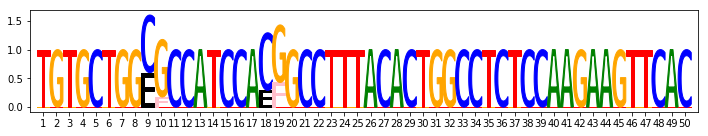

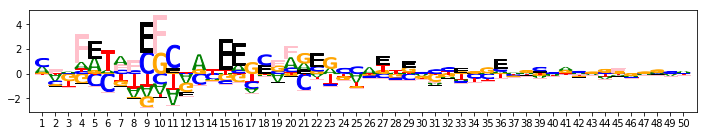

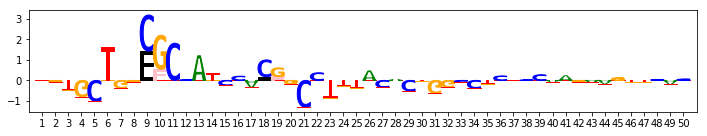

In [196]:
index = 1100
lower = 400
upper = 450

fig = seqlogo_fig(concat_scores_dict['raw'][index][lower:upper],vocab = 'Meth_6_channel')
fig_input_grad_seq = seqlogo_fig(concat_scores_dict['grad'][index][lower:upper],vocab='Meth_6_channel')
fig_seq_meth = seqlogo_fig(concat_scores_dict['input_grad'][index][lower:upper],vocab='Meth_6_channel')

In [171]:
scores_dict['raw']['meth'][1100,417:419]

array([0.29166666, 0.42857143], dtype=float32)

In [173]:
from copy import deepcopy
scores_copy = deepcopy(scores_dict)


In [175]:
scores_copy['raw']['meth'][1100,417:419]

array([0.29166666, 0.42857143], dtype=float32)

In [118]:
index = 1100
loc_idxs = np.arange(425,450)
locs = [(index,i) for i in loc_idxs]
vals = [0.0]*len(locs)
for idx,val in zip(locs,vals):
    print(idx,val,scores_copy['raw']['meth'][idx])
    scores_copy['raw']['meth'][idx] = val

((2000, 425), 0.0, 0.0)
((2000, 426), 0.0, 0.75)
((2000, 427), 0.0, 0.61904764)
((2000, 428), 0.0, 0.0)
((2000, 429), 0.0, 0.0)
((2000, 430), 0.0, 0.0)
((2000, 431), 0.0, 0.0)
((2000, 432), 0.0, 0.875)
((2000, 433), 0.0, 0.88235295)
((2000, 434), 0.0, 1.0)
((2000, 435), 0.0, 0.88235295)
((2000, 436), 0.0, 0.0)
((2000, 437), 0.0, 0.0)
((2000, 438), 0.0, 0.0)
((2000, 439), 0.0, 0.0)
((2000, 440), 0.0, 0.0)
((2000, 441), 0.0, 0.0)
((2000, 442), 0.0, 0.0)
((2000, 443), 0.0, 0.0)
((2000, 444), 0.0, 0.0)
((2000, 445), 0.0, 0.0)
((2000, 446), 0.0, 0.0)
((2000, 447), 0.0, 0.0)
((2000, 448), 0.0, 0.0)
((2000, 449), 0.0, 0.0)


In [120]:
scores_copy['raw']['meth'][2000,425:450]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [209]:
mod_scores = get_modified_importance_scores(scores_dict,locs,vals,model)

In [210]:
concat_mod_scores =  get_concat_scores(mod_scores)

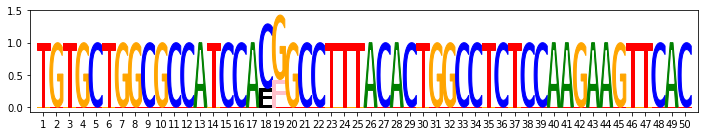

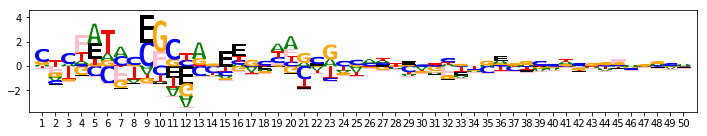

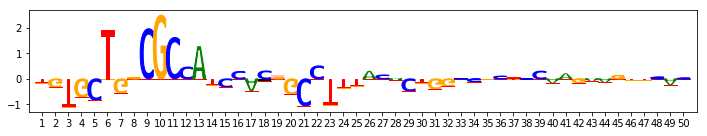

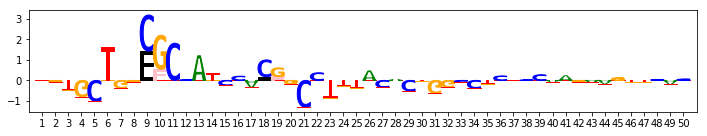

In [211]:
index = 1100
lower = 400
upper = 450
fig = seqlogo_fig(concat_mod_scores['raw'][index][lower:upper],vocab = 'Meth_6_channel')
fig_input_grad_seq = seqlogo_fig(concat_mod_scores['grad'][index][lower:upper],vocab='Meth_6_channel')
fig_seq_meth = seqlogo_fig(concat_mod_scores['input_grad'][index][lower:upper],vocab='Meth_6_channel')
fig_seq_meth_old = seqlogo_fig(concat_scores_dict['input_grad'][index][lower:upper],vocab='Meth_6_channel')

In [135]:
def get_preds(dict_scores,model):
    seq = dict_scores['raw']['seq']
    meth = dict_scores['raw']['meth']
    preds = model.predict([seq,meth]).squeeze()
    return preds

In [208]:

index = 1100
loc_idxs = np.arange(408,410)
locs = [(index,i) for i in loc_idxs]
vals = [0.0]*len(locs)
mod_scores = get_modified_importance_scores(scores_dict,locs,vals,model)




In [207]:
mod_scores['raw']['meth'][1100,408:410]

array([0.6      , 0.1764706], dtype=float32)

In [212]:
preds = get_preds(scores_dict,model)
preds_mod  = get_preds(mod_scores,model)

In [213]:
np.argmax(preds-preds_mod)

1100

In [214]:
preds[1100],preds_mod[1100]

(0.67745405, 0.14400712)

In [216]:
-np.log(preds_mod[1100]/preds[1100])

1.5484791